In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle

from glob import iglob
import datetime

In [2]:
import importlib
import src.pipeline as pipeline

In [265]:
importlib.reload(pipeline)

<module 'src.pipeline' from '/Users/vinsonmccready/galvanize/loan-default-predictor/src/pipeline.py'>

In [3]:
data = pipeline.get_all_data('data/raw/')

In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,year,date
0,145217616,NaN,10000,10000,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,0018-12-01
1,145640422,NaN,2500,2500,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,0018-12-01
2,145630143,NaN,12000,12000,12000.0,60 months,13.56%,276.49,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,0018-12-01
3,145127870,NaN,15000,15000,14975.0,60 months,14.47%,352.69,C,C2,...,0.0,0.0,16.0,48.8,15.0,0.0,0.0,NaN,18,0018-12-01
4,145558466,NaN,16000,16000,16000.0,60 months,17.97%,406.04,D,D1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,0018-12-01


In [11]:
with open('data/X_drop.pickle', 'rb') as f:
    cols = pickle.load(f)

In [12]:
drop = cols

## Data
The data includes loans that are not complete. I will be looking primarily at loans that are either fully paid off or charged off. 

In [5]:
data['loan_status'].value_counts()

Current               2086919
Fully Paid             552459
Charged Off            131231
Late (31-120 days)      32304
In Grace Period         22089
Issued                  21294
Late (16-30 days)        8147
Default                    29
Name: loan_status, dtype: int64

Additional analysis may be done on joint applications, but for the purposes of this predictor I will only be using individual applicants. 

In [6]:
data['application_type'].value_counts()

INDIVIDUAL    1359464
Individual    1284175
Joint App      194206
JOINT           13707
DIRECT_PAY       2920
Name: application_type, dtype: int64

In [7]:
# Only use individual loan types
data = pipeline.individual_data(data)
data['application_type'].unique()

array(['Individual', 'INDIVIDUAL'], dtype=object)

In [8]:
data.shape[0]

2643639

### Missing Data
There is a significant amount of missing data in some columns. These however are still very useful columns and the null value generally indicates a 0 value. 

In [9]:
# Columns with missing data

data[data.columns[data.isnull().sum()/data.shape[0] > .2]].isnull().sum()/data.shape[0]

member_id                              1.000000
desc                                   0.963374
mths_since_last_delinq                 0.519161
mths_since_last_record                 0.850447
next_pymnt_d                           0.254702
mths_since_last_major_derog            0.744397
annual_inc_joint                       1.000000
dti_joint                              1.000000
verification_status_joint              1.000000
open_acc_6m                            0.311407
open_il_12m                            0.311406
open_il_24m                            0.311406
mths_since_rcnt_il                     0.331586
total_bal_il                           0.311406
il_util                                0.407763
open_rv_12m                            0.311406
open_rv_24m                            0.311406
max_bal_bc                             0.311406
all_util                               0.311497
inq_fi                                 0.311406
total_cu_tl                            0

There are some columns that have 100% missing data; this will be handled before creating my training variable X. 

<AxesSubplot:>

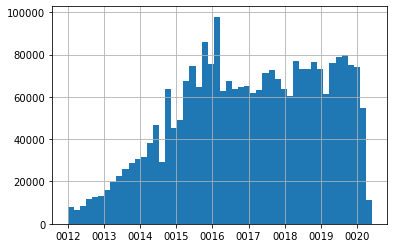

In [15]:
# Taking a look at values per year

data['date'].hist(bins=50)

In [16]:
# Average number of columns with missing values per row for each year

for y in np.sort(data['year'].unique()):
    print(y, data[data['year']==y].isna().sum().sum()/data[data['year']==y].shape[0])

12 48.52524968613562
13 34.57020042428828
14 34.36992899855281
15 33.481347364616816
16 21.1244878454973
17 21.127428152609642
18 21.35766216155981
19 21.398317451564527
20 21.34044473778718


### Preprocessing

In [17]:
# Clean data (change from string to numeric)

data = pipeline.clean_data(data)

In [18]:
# Looking at years of data available

np.sort(data['year'].unique())

array([12, 13, 14, 15, 16, 17, 18, 19, 20])

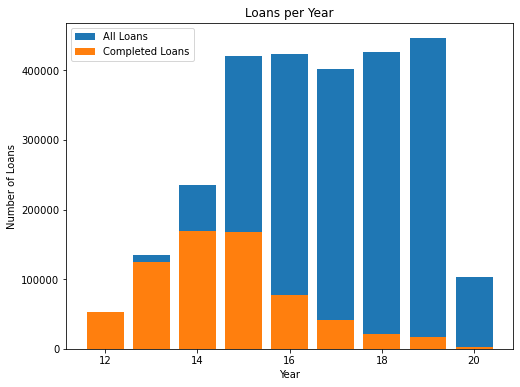

In [19]:
# Look at volumes of loans per year
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(data['year'].value_counts().index,data['year'].value_counts(), label='All Loans')
ax.bar(pipeline.completed_filter(data)['year'].value_counts().index,
       pipeline.completed_filter(data)['year'].value_counts(), 
       label='Completed Loans')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Loans')
ax.set_title('Loans per Year')
plt.legend()

From 2015 on we see fewer and fewer completed loans. This is because the terms can be up to 5 years. We will only be using data from early 2015 which have terms that should be complete from when this data was downloaded. 

In [20]:
# Looking at ratio of charged off loans per year. 
# Recent years are lower because they are not complete yet

data[data['loan_status']=='Charged Off'].groupby('year')['year'].count()/data.groupby('year')['year'].count()

year
12    0.160774
13    0.148375
14    0.147541
15    0.104954
16    0.037019
17    0.012335
18    0.002672
19    0.001715
20    0.000155
Name: year, dtype: float64

In [100]:
# with open('data/X_drop.pickle', 'wb') as f:
#     pickle.dump(drop, f)

In [157]:


(data['loan_status']=='Charged Off').sum()/data.shape[0]

0.04917728933489028

In [188]:
def ratio_defaulted(column, data):
    ratios = (data[data['loan_status']=='Charged Off'][column].value_counts(dropna=False)/
              data[column].value_counts(dropna=False)).sort_index().values
    vals = (data[data['loan_status']=='Charged Off'][column].value_counts(dropna=False)/
            data[column].value_counts(dropna=False)).sort_index().index.values
    if type(vals[-1])==float:
        vals[-1]='NA'
    return vals, ratios

In [250]:
def plot_defaultrate_categorical(column, ax):
    ax.bar(ratio_defaulted(column, data)[0],
           ratio_defaulted(column, data)[1])

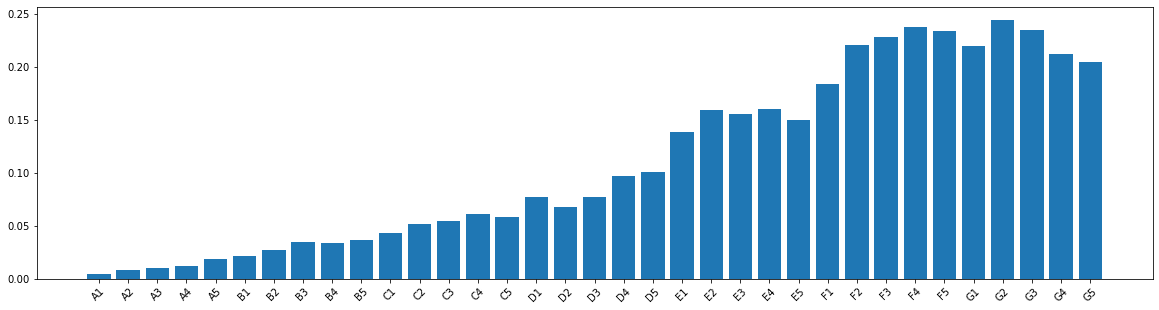

In [242]:
fig, ax = plt.subplots(figsize=(20,5))

plot_defaultrate_categorical('sub_grade', ax=ax)
plt.xticks(rotation=45)
plt.show()

In [182]:
# Missing values
pipeline.print_missing(data.drop(drop, axis=1)[data['year'] > 12])

'inq_last_6mths': number of missing values '1' ==> '0.000%'
'mths_since_last_delinq': number of missing values '1341074' ==> '51.773%'
'mths_since_last_record': number of missing values '2196381' ==> '84.793%'
'revol_util': number of missing values '2006' ==> '0.077%'
'mths_since_last_major_derog': number of missing values '1919932' ==> '74.121%'
'open_acc_6m': number of missing values '769880' ==> '29.722%'
'open_il_12m': number of missing values '769879' ==> '29.722%'
'open_il_24m': number of missing values '769879' ==> '29.722%'
'mths_since_rcnt_il': number of missing values '823228' ==> '31.782%'
'total_bal_il': number of missing values '769879' ==> '29.722%'
'il_util': number of missing values '1024610' ==> '39.556%'
'open_rv_12m': number of missing values '769879' ==> '29.722%'
'open_rv_24m': number of missing values '769879' ==> '29.722%'
'max_bal_bc': number of missing values '769879' ==> '29.722%'
'all_util': number of missing values '770119' ==> '29.731%'
'inq_fi': number of 

<AxesSubplot:>

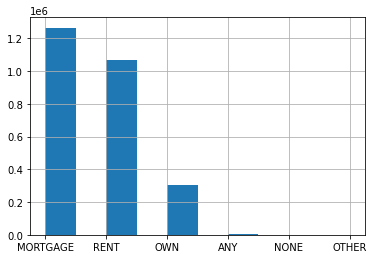

In [254]:
data['home_ownership'].hist()

In [256]:
data['date']

0          0018-12-01
1          0018-12-01
2          0018-12-01
4          0018-12-01
5          0018-12-01
              ...    
2854467    0016-10-01
2854468    0016-10-01
2854469    0016-10-01
2854470    0016-10-01
2854471    0016-10-01
Name: date, Length: 2643639, dtype: object

In [273]:
data['earliest_cr_line'] = data['earliest_cr_line'].apply(pipeline.get_date)

In [276]:
data['date'] = data['issue_d'].apply(pipeline.get_date)

In [285]:
data['days_earlist_cr'] = (data['date']-data['earliest_cr_line']).apply(lambda x: x.days)

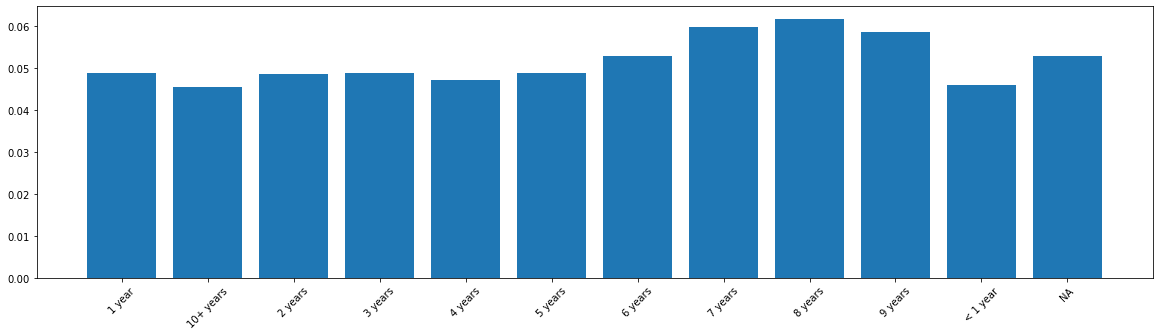

In [251]:
fig, ax = plt.subplots(figsize=(20,5))

plot_defaultrate_categorical('emp_length', ax=ax)
plt.xticks(rotation=45)
plt.show()

In [252]:
drop

['member_id',
 'desc',
 'next_pymnt_d',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'funded_amnt_inv',
 'grade',
 'emp_title',
 'emp_length',
 'pymnt_plan',
 'url',
 'title',
 'zip_code',
 'earliest_cr_line',
 'fico_range_high',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_credit_pull_d',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'delinq_amnt',
 'application_type',
 'issue_d',
 'id',
 'loan_status',
 'year',
 'dat

### Create X and y variables

In [186]:
import src.model as model

In [339]:
importlib.reload(pipeline)

<module 'src.pipeline' from '/Users/vinsonmccready/galvanize/loan-default-predictor/src/pipeline.py'>

In [303]:
# Create training set using earlier data. Only looking at completed loans. 
# Only looking at 36 month loans. 

training = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2012, 1,1), datetime.date(2016, 1,1), 
    pipeline.term_filter(36,
    pipeline.create_dummies(data))))

In [304]:
X_train = pipeline.create_X(training, drop)
y_train = pipeline.create_y(training)

In [305]:
X_train.shape

(391861, 125)

In [306]:
# drop.append('addr_state')

In [307]:
# Holdout data will be later data that has completed 36 month loans. 

test = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2016, 1,1), datetime.date(2017, 4,1), 
    pipeline.term_filter(36,
    pipeline.create_dummies(data))))

In [308]:
X_test = pipeline.create_X(test, drop)
y_test = pipeline.create_y(test)

In [309]:
# validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])]['loan_status'].unique()

In [310]:
# X_val = pipeline.create_X(validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])], drop)
# y_val = pipeline.create_y(validation[~validation['loan_status'].str.lower().isin(['fully paid', 'charged off'])])

In [311]:
for c in X_train.columns:
    if c not in X_test.columns:
        print(c)

In [312]:
print(X_train.shape)
print(X_test.shape)

(391861, 125)
(62239, 125)


In [313]:
# Make sure validation set is ok ratio of data. 
X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])

0.13706011891653821

### Models

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score

In [52]:
# X_train, X_test, y_train, y_test = train_test_split(X,y)

In [314]:
rf_model = RandomForestClassifier(n_jobs=-1, random_state=1)
rf_model.fit(X_train, y_train)
recall = recall_score(y_test, rf_model.predict(X_test))
precision = precision_score(y_test, rf_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.05697095045595563
Precision: 0.5083892617449665


In [319]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
recall = recall_score(y_test, gb_model.predict(X_test))
precision = precision_score(y_test, gb_model.predict(X_test))
print(f'Recall: {recall}\nPrecision: {precision}')

Recall: 0.05565478988436589
Precision: 0.5229681978798587


In [50]:
from sklearn.metrics import roc_auc_score

In [230]:
roc_auc_score(y_test, rf_model.predict(X_test))

0.5229111017510572

In [52]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

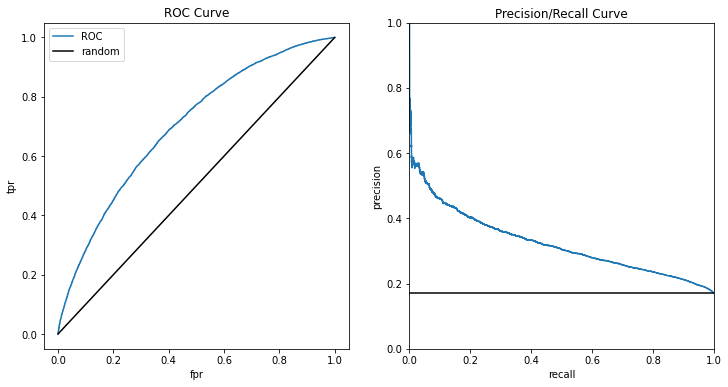

In [231]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(rf_model.predict_proba(X_test)[:,1], y_test)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)

In [232]:
probabilities = rf_model.predict_proba(X_test)

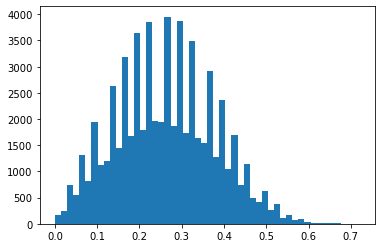

In [233]:
fig, ax = plt.subplots()
ax.hist(probabilities[:,1], bins=50);

In [234]:
(probabilities > .5).sum()

61951

In [235]:
y_test.sum()

10637

In [236]:
threshold = np.linspace(0,1,50)
yhat = rf_model.predict_proba(X_test)[:,1]

recall = []
precision = []
for t in threshold:
    c = pd.crosstab(pd.Categorical(y_test, categories=[0,1]), 
                    pd.Categorical(yhat>t, categories=[0,1]), 
                    rownames=['actual'], 
                    colnames=['predicted'],
                    dropna=False)
    r = c[1][1]/(c[1][1]+c[0][1])
    p = c[1][1]/(c[1][1]+c[1][0])
    recall.append(r)
    precision.append(p)

<ipython-input-236-6ed33272057a>:13: RuntimeWarning: invalid value encountered in long_scalars
  p = c[1][1]/(c[1][1]+c[1][0])


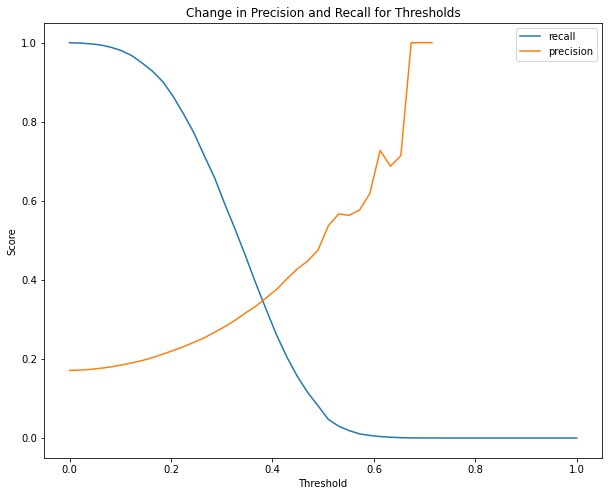

In [237]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(threshold, recall, label='recall')
ax.plot(threshold, precision, label='precision')
# ax.vlines([.08, .85], 0,1, linestyles='--', colors='green')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Change in Precision and Recall for Thresholds')
plt.show()

In [60]:
y_prob = rf_model.predict_proba(X_test)[:,1]

In [61]:
# make predictions based on probabilities and threshold
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 1 is the positive class'''
    return np.where(model.predict_proba(X)[:,1] > threshold, 1, 0)

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, y,  threshold=0.5):
    cf = pd.crosstab(y, predict(model, X, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=[0, 1], index=[0, 1]), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).values.sum()

In [62]:
rf_model.classes_

array([0, 1])

In [63]:
cf = confusion_matrix(rf_model, X_test, y_test)

In [64]:
cf

predicted,0,1
actual,,
0,51015,587
1,10041,596


In [65]:
cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [66]:
cb_matrix

predicted,0,1
actual,,
0,0,-20
1,0,10


In [67]:
calculate_payout(cb_matrix, rf_model, X_test, y_test, .5)

-5780

In [68]:
-10*6414 + 26550 * 10

201360

In [69]:
# Cost benefit
def get_profits(model, X, y):
    cb_matrix = pd.DataFrame([[0, -20], [0, 10]], columns=[0, 1], index=[0,1])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.05)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, y, threshold))
    return profits
    
    
def profit_curve(profits, ax):
    thresholds = np.arange(0.0, 1.0, 0.05)
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')
    print(profits)

In [70]:
profits = get_profits(rf_model, X_test, y_test)

Text(0.5, 1.0, 'Profit Curve')

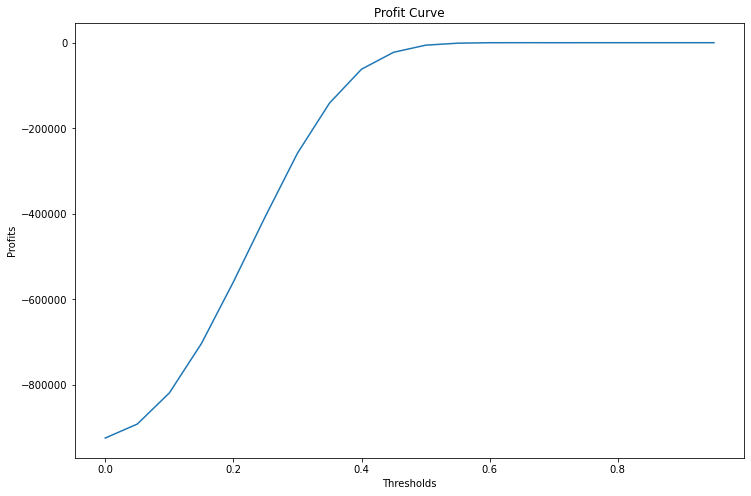

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
thresholds = np.arange(0.0, 1.0, 0.05)
ax.plot(thresholds, profits)
ax.set_xlabel('Thresholds')
ax.set_ylabel('Profits')
ax.set_title('Profit Curve')
# ax.set_ylim(-250000, 200000)

In [72]:
def get_yhat(probs, threshold):
    return probs > threshold

In [73]:
def get_cf_arrays(y_true, y_hat):
    true_positive = (y_true == 1) & (y_hat==1)
    true_negative = (y_true == 0) & (y_hat==0)
    false_positive = (y_true == 0) & (y_hat==1)
    false_negative = (y_true == 1) & (y_hat==0)
    return true_positive, true_negative, false_positive, false_negative

In [74]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .65))

In [75]:
tp.sum() + tn.sum() + fp.sum() + fn.sum()

62239

In [76]:
y_test.shape[0]

62239

In [77]:
data.loc[y_test.index[tp]]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,year,date
2420469,84060200,NaN,7200,7200,7200.0,36,25.69,288.91,F,F1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-06-01
2456240,78982417,NaN,15200,15200,15200.0,36,23.99,596.26,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-05-01
2470362,77376812,NaN,33575,33575,33325.0,36,25.88,1350.62,F,F4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-05-01
2492357,75131935,NaN,6600,6600,6600.0,36,13.67,224.52,C,C3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-04-01
2499638,77210339,NaN,5775,5775,5775.0,36,22.45,221.90,E,E5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-04-01
2509007,75350223,NaN,6000,6000,5950.0,36,28.34,249.29,G,G3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-04-01
2540854,88222196,NaN,2075,2075,2075.0,36,27.79,85.60,F,F5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-09-01
2553850,88077424,NaN,9000,9000,9000.0,36,26.49,364.97,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-08-01
2557556,88022186,NaN,10000,10000,10000.0,36,27.79,412.51,F,F5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-08-01
2620874,74904477,NaN,28000,28000,28000.0,36,26.57,1136.66,F,F5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0016-03-01


In [78]:
payment = [
    'loan_amnt', 
    'funded_amnt',
    'out_prncp',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee']

In [79]:
data.loc[y_test.index[tp]][payment]

,loan_amnt,funded_amnt,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee
2420469,7200,7200,0.0,0.0,1841.04,1841.04,413.03,428.01,0.0
2456240,15200,15200,0.0,0.0,3320.68,3320.68,894.81,883.83,0.0
2470362,33575,33575,0.0,0.0,8055.45,7995.47,3967.72,4087.73,0.0
2492357,6600,6600,0.0,0.0,1120.09,1120.09,763.88,356.21,0.0
2499638,5775,5775,0.0,0.0,2455.62,2455.62,1376.44,1079.18,0.0
2509007,6000,6000,0.0,0.0,987.71,979.48,445.85,541.86,0.0
2540854,2075,2075,0.0,0.0,218.00,218.00,79.67,138.33,0.0
2553850,9000,9000,0.0,0.0,1164.54,1164.54,509.97,654.57,0.0
2557556,10000,10000,0.0,0.0,2097.29,2097.29,947.52,1149.77,0.0
2620874,28000,28000,0.0,0.0,10188.61,10188.61,5084.10,5104.51,0.0


In [80]:
data[data.loan_amnt != data.funded_amnt][payment]

,loan_amnt,funded_amnt,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee
178659,5000,3400,0.00,0.00,3643.290000,3643.29,3400.00,243.29,0.0
179511,2875,2850,0.00,0.00,3181.145363,3181.15,2850.00,331.15,0.0
216117,33425,33325,9488.48,9474.25,42131.039690,42067.83,23836.52,18294.52,0.0
220369,32000,31900,0.00,0.00,33855.959850,33829.43,31900.00,1955.96,0.0
221038,25000,24975,0.00,0.00,26453.004910,26453.00,24975.00,1478.00,0.0
...,...,...,...,...,...,...,...,...,...
316583,35000,22550,0.00,0.00,22724.800000,22724.80,14480.92,8232.35,0.0
316586,20000,12675,0.00,0.00,17801.931680,17801.93,12675.00,5126.93,0.0
316592,12000,7775,0.00,0.00,11163.948260,11163.95,7775.00,3388.95,0.0
2452445,18000,10000,6601.71,6601.71,4485.580000,4485.58,3398.29,1087.29,0.0


In [81]:
data.loc[:,payment].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2643639 entries, 0 to 2854471
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loan_amnt           int64  
 1   funded_amnt         int64  
 2   out_prncp           float64
 3   out_prncp_inv       float64
 4   total_pymnt         float64
 5   total_pymnt_inv     float64
 6   total_rec_prncp     float64
 7   total_rec_int       float64
 8   total_rec_late_fee  float64
dtypes: float64(7), int64(2)
memory usage: 266.2 MB


In [82]:
(data.loc[y_test.index[tp]]['funded_amnt'].sum()-data.loc[y_test.index[tp]]['total_rec_prncp'].sum())/y_test.index[tp].shape[0]

10894.201

In [83]:
data.loc[y_test.index[fp]]['total_rec_int'].sum()

2646.08

In [84]:
def potential_principal_saved(tp, fp, interest=False):
    # Principal remaining
    funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
    princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
    int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
    missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
    recovered = data.loc[y_test.index[tp]]['recoveries'].sum()
    saved = funded - princ_rec - missed_int - int_rec - recovered
    if interest:
        saved -= int_rec
    return saved
    

In [85]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp))

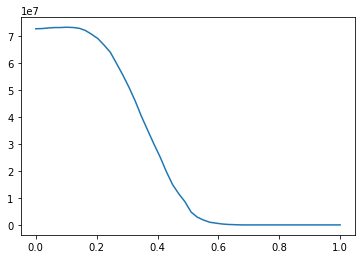

In [86]:
fig, ax = plt.subplots()

ax.plot(threshold, savings)

In [87]:
savings = []
for t in threshold:
    tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], t))
    savings.append(potential_principal_saved(tp, fp, True))


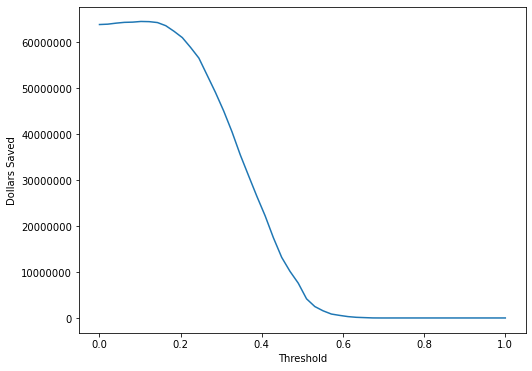

In [88]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, savings)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')
ax.ticklabel_format(style='plain')

### Find savings from future loans

In [106]:
threshold[np.argmax(savings)]

0.22448979591836732

In [71]:
tp, tn, fp, fn = get_cf_arrays(y_test, get_yhat(probabilities[:,1], .8))

In [72]:
funded = data.loc[y_test.index[tp]]['funded_amnt'].sum()
princ_rec = data.loc[y_test.index[tp]]['total_rec_prncp'].sum()
int_rec = data.loc[y_test.index[tp]]['total_rec_int'].sum()
missed_int = data.loc[y_test.index[fp]]['total_rec_int'].sum()
recovered = data.loc[y_test.index[tp]]['recoveries'].sum()
saved = funded - princ_rec - missed_int - int_rec - recovered
saved

59401792.78999999

In [73]:
current_loan_prob = rf_model.predict_proba(X_val)

In [ ]:
#

In [74]:
def interest_calculator(funded, interest, payment):
    current_balance = funded
    r = interest/100
    interest_paid = 0
    while current_balance > 0:
        accrued = (current_balance * r)/12
        interest_paid += accrued
        current_balance -= (payment - accrued)
        if interest_paid > funded:
            return 0
    return round(interest_paid,2)
    

In [77]:
validation['potential_interest'] = validation.apply(lambda row: interest_calculator(row['funded_amnt'], row['int_rate'], row['installment']), axis=1)

<ipython-input-77-39f67147d747>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['potential_interest'] = validation.apply(lambda row: interest_calculator(row['funded_amnt'], row['int_rate'], row['installment']), axis=1)


In [76]:
interest_calculator(data.loc[0, 'funded_amnt'], data.loc[0, 'int_rate'], data.loc[0, 'installment'])

1672.0

In [78]:
validation['potential_interest']

0           1672.00
1            556.71
2           4589.33
4           8361.80
5           3850.20
             ...   
2420059    29067.86
2420060     4782.94
2420062     1955.40
2420063    10565.62
2420064     7660.90
Name: potential_interest, Length: 1376521, dtype: float64

In [85]:
validation.loc[y_val.index[current_loan_prob[:,1] > .5]]['potential_interest'].sum()

127019778.61

In [87]:

potential_interest = []
for t in threshold:
    potential_interest.append(validation.loc[y_val.index[current_loan_prob[:,1] > t]]['potential_interest'].sum())

Text(0, 0.5, 'Dollars Saved')

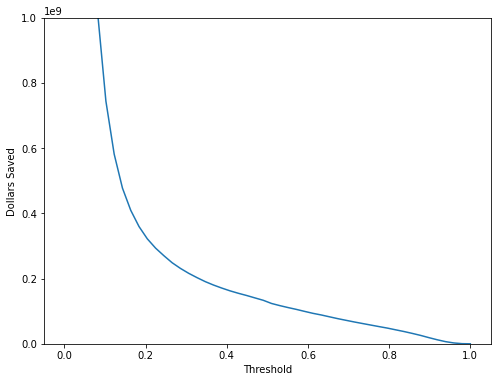

In [101]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(threshold, np.array(potential_interest))
ax.set_ylim(0,1000000000)
ax.set_xlabel('Threshold')
ax.set_ylabel('Dollars Saved')

In [89]:
net = np.array(savings)-np.array(potential_interest)

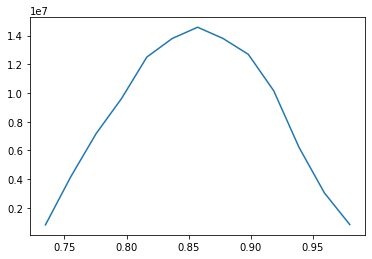

In [106]:
fig, ax = plt.subplots()

ax.plot(threshold[net>0],net[net > 0])

In [103]:
threshold[net > 0]

array([0.73469388, 0.75510204, 0.7755102 , 0.79591837, 0.81632653,
       0.83673469, 0.85714286, 0.87755102, 0.89795918, 0.91836735,
       0.93877551, 0.95918367, 0.97959184])

In [320]:
loans2012_2017 = pipeline.completed_filter(
    pipeline.date_filter(datetime.date(2012, 1,1), datetime.date(2017, 4,1), 
    pipeline.term_filter(36, data)))

In [325]:
funded = loans2012_2017[loans2012_2017['loan_status']=='Fully Paid']['funded_amnt'].sum()
princ_rec = loans2012_2017[loans2012_2017['loan_status']=='Fully Paid']['total_rec_prncp'].sum()
int_rec = loans2012_2017[loans2012_2017['loan_status']=='Fully Paid']['total_rec_int'].sum()
recovered = loans2012_2017[loans2012_2017['loan_status']=='Fully Paid']['recoveries'].sum()


In [323]:
a = funded - princ_rec - int_rec - recovered

In [327]:
b = funded - princ_rec - int_rec - recovered

In [328]:
a+b

-157428232.6400001

In [329]:
a

471319912.18000007